In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
import pandas as pd
import seaborn as sns
import cv2
import scipy.misc
import scipy.ndimage
import imutils
from tkinter import filedialog
from tkinter import *
global fileNo
import os
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from sklearn.metrics import confusion_matrix,classification_report

In [3]:
data = r'skin cancer project\dataset'
benign = glob.glob(r'dataset\benign\*.jpg')
malignant = glob.glob(r'dataset\malignant\*.jpg')
print('Number of images with benign : {}'.format(len(benign)))
print('Number of images with malignant : {}'.format(len(malignant)))

Number of images with benign : 360
Number of images with malignant : 299


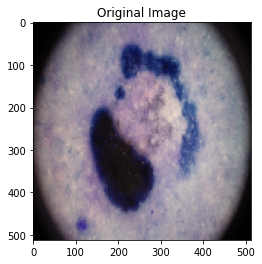

In [4]:
root = Tk()
root.withdraw()
options = {}
options['initialdir'] = 'RGB/'

options['mustexist'] = False
file_selected = filedialog.askopenfilename(title = "Select file",filetypes = (("JPEG files","*.jpg"),("all files","*.*")))
head_tail = os.path.split(file_selected)
fileNo=head_tail[1].split('.')
Image = cv2.imread(head_tail[0]+'/'+fileNo[0]+'.jpg')
Image1=Image[:,:,0]
img=cv2.resize(Image,(512,512))
plt.title('Original Image')
plt.imshow(img)

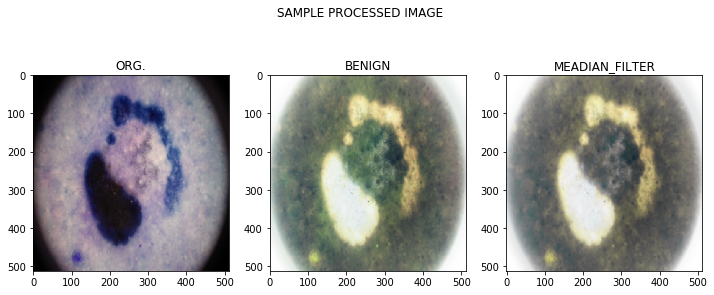

In [5]:
benign_ = img
benign_ = 255 - benign_
median_filtered = scipy.ndimage.median_filter(benign_, size=3)

fig, ax = plt.subplots(1, 3, figsize=(10, 8));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORG.', fontsize=12)
ax[1].set_title('BENIGN', fontsize=12)
ax[2].set_title('MEADIAN_FILTER', fontsize=12)

ax[0].imshow(255-benign_, cmap='gray');
ax[1].imshow(benign_, cmap='gray');
ax[2].imshow(median_filtered, cmap='gray');

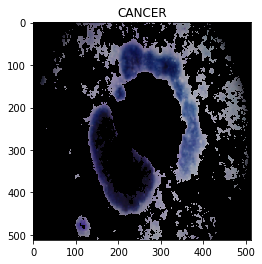

In [6]:
min_YCrCb = np.array([0,133,77],np.uint8)
max_YCrCb = np.array([235,173,127],np.uint8)

# Get pointer to video frames from primary device
image = img
imageYCrCb = cv2.cvtColor(image,cv2.COLOR_BGR2YCR_CB)
skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
skinYCrCb = cv2.bitwise_and(image, image, mask = skinRegionYCrCb)
plt.title('CANCER')
plt.imshow(skinYCrCb)

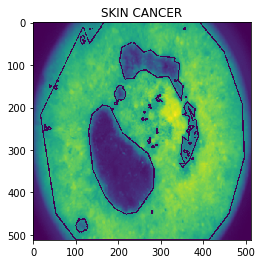

In [7]:
img1 = img
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# Converting image to a binary image
# ( black and white only image).
_, threshold = cv2.threshold(img1, 110, 255, cv2.THRESH_BINARY)

# Detecting contours in image.
contours= cv2.findContours(threshold, cv2.RETR_TREE,
							cv2.CHAIN_APPROX_SIMPLE)[1]

# Going through every contours found in the image.
for cnt in contours :

	approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)

	# draws boundary of contours.
	cv2.drawContours(img1, [approx], 0, (0, 50, 255), 2)

plt.show()
plt.title('SKIN CANCER')
plt.imshow(img1)

In [8]:
lst_benign = []
for x in benign:
  lst_benign.append([x,1])
lst_malignant = []
for x in malignant:
  lst_malignant.append([x,0])
lst_complete = lst_benign + lst_malignant
random.shuffle(lst_complete)

In [9]:
df = pd.DataFrame(lst_complete,columns = ['files','target'])
df.head(10)
filepath_img ="benign/malignant/*.jpg"
df = df.loc[~(df.loc[:,'files'] == filepath_img),:]
df.shape

(659, 2)

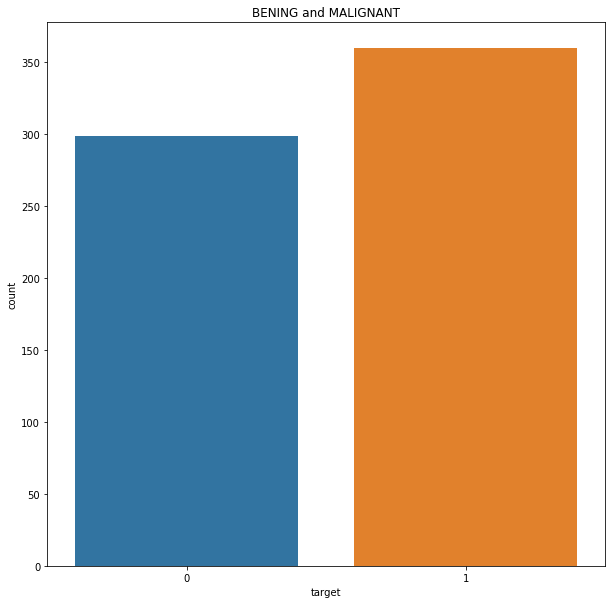

In [10]:
plt.figure(figsize = (10,10))
sns.countplot(x = "target",data = df)
plt.title("BENING and MALIGNANT") 
plt.show()

In [11]:
#covert images into array
def preprocessing_image(filepath):
  img = cv2.imread(filepath) #read
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
  img = cv2.resize(img,(196,196))  # resize
  img = img / 255 #scale
  return img

In [12]:
def create_format_dataset(dataframe):
  X = []
  y = []
  for f,t in dataframe.values:
    X.append(preprocessing_image(f))
    y.append(t)
  
  return np.array(X),np.array(y)

In [13]:
X, y = create_format_dataset(df)
X.shape,y.shape
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,stratify = y)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((527, 196, 196, 3), (132, 196, 196, 3), (527,), (132,))

In [14]:

'''CNN'''
print('Convolutional Neural Network')
CNN = Sequential()

CNN.add(Conv2D(32,(2,2),input_shape = (196,196,3),activation='relu'))
CNN.add(Conv2D(64,(2,2),activation='relu'))
CNN.add(MaxPooling2D())
CNN.add(Conv2D(32,(2,2),activation='relu'))
CNN.add(MaxPooling2D())

CNN.add(Flatten())
CNN.add(Dense(32))
CNN.add(Dense(1,activation= "sigmoid"))
CNN.summary()

Convolutional Neural Network
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 195, 195, 32)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 194, 194, 64)      8256      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 97, 97, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 73728

In [15]:
CNN.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
CNN.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 10,batch_size = 5)
print("Accuracy of the CNN is:",CNN.evaluate(X_train,y_train)[1]*100, "%")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 527 samples, validate on 132 samples
Epoch 1/10
527/527 [==============================] - 314s 596ms/sample - loss: 1.1540 - acc: 0.5294 - val_loss: 0.6733 - val_acc: 0.6061
Epoch 2/10
527/527 [==============================] - 279s 529ms/sample - loss: 0.6401 - acc: 0.6452 - val_loss: 0.6477 - val_acc: 0.6061
Epoch 3/10
527/527 [==============================] - 276s 523ms/sample - loss: 0.6184 - acc: 0.6603 - val_loss: 0.6247 - val_acc: 0.6439
Epoch 4/10
527/527 [==============================] - 275s 522ms/sample - loss: 0.6215 - acc: 0.6528 - val_loss: 0.6339 - val_acc: 0.6288
Epoch 5/10
527/527 [==============================] - 270s 512ms/sample - loss: 0.6152 - acc: 0.6793 - val_loss: 0.6456 - val_acc: 0.5985
Epoch 6/10
527/527 [==============================] - 269s 511ms/sample - loss: 0.5958 - acc: 0.6641 - val_loss: 0.6309 - val_acc: 0.6136
Epoch 7/10
527/527 [============

In [16]:
history = CNN.history.history

#Plotting the accuracy
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['acc']
val_acc = history['val_acc']

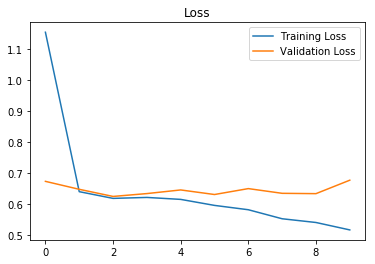

In [17]:
# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

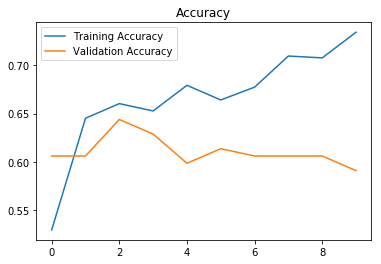

In [18]:
# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [19]:
y_pred = CNN.predict(X_test)
y_pred = y_pred.reshape(-1)
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1
y_pred = y_pred.astype('int')
y_pred

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [20]:
classification=classification_report(y_test,y_pred)
print('Classification Report')
print(classification)

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.15      0.25        60
           1       0.57      0.96      0.72        72

   micro avg       0.59      0.59      0.59       132
   macro avg       0.66      0.55      0.48       132
weighted avg       0.65      0.59      0.51       132



In [21]:
cm = confusion_matrix(y_test,y_pred)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[ 9 51]
 [ 3 69]]


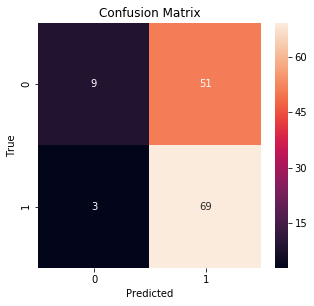

In [22]:
plt.figure(figsize = (5,4.5))
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()